<a href="https://colab.research.google.com/github/SeohyunLyoo/Study/blob/main/Seq2Seq%20%2B%20Attention%20-%20Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Study



/content/drive/MyDrive/Study


# **1. 데이터 준비 및 불용어 취합**

In [5]:
data = pd.read_csv('Reviews.csv', nrows = 100000)
print(len(data)), print(data.info())

100000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99994 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99998 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB
None


(None, None)

In [6]:
data.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,6
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,2
Text,0


In [7]:
df = data[['Text', 'Summary']]
df.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [8]:
### Text 및 Summary 항목 중복 여부 체크
df['Text'].nunique(), df['Summary'].nunique()

(88426, 72348)

In [9]:
### Text열 중복 데이터 삭제 (Summary는 중복 데이터 유지, Text에 대한 동일 Summary 지원)
df.drop_duplicates(subset = ['Text'], inplace = True)
print(len(df))

88426


In [10]:
### Text 및 Summary Null 값 여부 확인
df['Text'].isnull().sum(), df['Summary'].isnull().sum()

(0, 1)

In [11]:
### Summary 항목 null 값인 데이터 삭제
df.dropna(axis=0, inplace=True)
df['Text'].isnull().sum(), df['Summary'].isnull().sum()

(0, 0)

In [12]:
### 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


In [13]:
### NLTK 불용어 취합
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
len(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


179

In [14]:
print(stop_words)

{'for', 'has', 'he', 'below', 'hasn', 'not', 'each', 'where', "don't", 've', 'to', 'theirs', 'through', 'further', 'yours', 'there', 'needn', 'mightn', 'wouldn', 'while', 'under', 'herself', 'which', "isn't", 'about', 'ain', 'more', 's', "didn't", 'your', 'y', 'hadn', 'or', "haven't", 'but', 'until', 'will', 'so', 'd', 'm', "wasn't", "wouldn't", 'themselves', 'couldn', 'our', "you're", "mightn't", 'at', 'out', 'ourselves', 'on', 'how', 'haven', 'both', 'up', 'these', "doesn't", 'had', 'after', 'did', 'itself', 'by', 'its', "should've", 'be', "she's", 'too', 'them', 'why', 'same', 'just', 'own', 'wasn', 'those', "shan't", 'is', 'my', 'ours', 'off', 'doing', "it's", 'down', "you've", 'does', 'she', 'him', 'are', 'o', 'over', 'weren', 'above', 'isn', 'have', 'having', 'me', "aren't", 'no', 'as', 'whom', 'once', 'a', 'am', 'doesn', "needn't", 'of', 'only', 'other', 'hers', 'who', 'most', 'himself', 'between', 'some', 'an', "shouldn't", 'here', 'few', 'didn', 'shan', 'what', 'then', 'from',

# **2. 데이터 전처리**

In [15]:
### !pip install contractions
### import contractions

In [16]:
def preprocess_sentence(sentence, remove_stopwords=True):

    if not isinstance(sentence, str):
        sentence = str(sentence)

    sentence = sentence.lower()                             ### 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text         ### ,  등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)           ### 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence)                     ### 쌍따옴표 " 제거

    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])           ### 약어 정규화
    ###sentence = ' '.join([contractions.fix(t) for t in sentence.split(" ")])

    sentence = re.sub(r"'s\b","",sentence)                  ### 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)           ### 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)            ### m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    ### 불용어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    ### 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)

    return tokens

In [17]:
### Text : 불용어 제거, Summary : 불용어 유지
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [18]:
### Text 전처리
clean_text = []

for s in df['Text']:
    clean_text.append(preprocess_sentence(s))

print(clean_text[:5])

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [19]:
### Summary 전처리
clean_summary = []

for s in df['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))

clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [20]:
df['Text'] = clean_text
df['Summary'] = clean_summary
df.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [21]:
# 길이가 공백인 샘플은 NULL 값으로 변환
df.replace('', np.nan, inplace=True)
print(df.isnull().sum())

Text        0
Summary    70
dtype: int64


In [22]:
### SUMMARY 항목이 NULL인 경우 해당 건 삭제
df.dropna(axis=0, inplace=True)
len(df)

88355

In [23]:
df.isnull().sum()

,0
Text,0
Summary,0


In [24]:
### Text / Summary Padding Size 결정
text_max_len = 50
summary_max_len = 10

In [25]:
df = df[df['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
df = df[df['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 67579


In [26]:
df[:5]

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [27]:
### decoder_input, decoder_output 시작/종료 토큰 추가
df['decoder_input'] = df['Summary'].apply(lambda x : 'sostoken ' + x)
df['decoder_output'] = df['Summary'].apply(lambda x : x + ' eostoken')
df.head()

,Text,Summary,decoder_input,decoder_output
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [28]:
### Encoder / Decoder의 레이블 지정
encoder_input  = np.array(df['Text'])
decoder_input  = np.array(df['decoder_input'])
decoder_target = np.array((df['decoder_output']))

In [29]:
### 훈련/테스트 데이터 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [31]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13515


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [33]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 54064
훈련 레이블의 개수 : 54064
테스트 데이터의 개수 : 13515
테스트 레이블의 개수 : 13515


# **3. 정수 인코딩**

**1) 단어 집합 생성**

In [34]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [35]:
### 단어 등장 횟수 7회 미만 단어들은 자연어 처리에서 제외
threshold = 7

total_cnt = len(src_tokenizer.word_index)   ### 단어의 수
rare_cnt = 0                                ### 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                              ### 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               ### 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

### 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    ### 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32628
등장 빈도가 6번 이하인 희귀 단어의 수: 24227
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8401
단어 집합에서 희귀 단어의 비율: 74.25217604511462
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.339588702482789


In [36]:
encoder_input_train[:3]

array(['great treat snak rv trips convenient whirly pop everything one pkg butter salt kernels little pricey everyday use well worth',
       'popcorn good makes half tast good like moive theater popcorn goooooooooooooooooood',
       'product good however delivered unpackaged box bag individual packetts came loosely brown paper even taped box way big tossed around looked old'],
      dtype=object)

In [37]:
### Encoder 단어 사전의 크기를 8,000으로 제한
src_vocab = 8000

src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

### 텍스트 시퀀스를 정수 시퀀스로 변경
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test  = src_tokenizer.texts_to_sequences(encoder_input_test)

encoder_input_train[:3]

[[3,
  103,
  6908,
  1772,
  416,
  5200,
  455,
  317,
  7,
  3800,
  192,
  124,
  1233,
  20,
  637,
  747,
  21,
  27,
  146],
 [161, 2, 78, 210, 3258, 2, 1, 1604, 161],
 [5,
  2,
  117,
  474,
  56,
  46,
  779,
  174,
  6586,
  469,
  1205,
  33,
  5201,
  56,
  55,
  153,
  2552,
  200,
  482,
  105]]

In [38]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [39]:
### Decoder 단어 사전의 크기를 8,000으로 제한
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

### 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train  = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test   = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test  = tar_tokenizer.texts_to_sequences(decoder_target_test)

**2) 빈 샘플 제거**

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test  = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 1243
삭제할 테스트 데이터의 개수 : 355


In [41]:
### Convert lists of lists to NumPy arrays with dtype=object (오류로 인한 추가 부분)
encoder_input_train  = np.array(encoder_input_train, dtype=object)
decoder_input_train  = np.array(decoder_input_train, dtype=object)
decoder_target_train = np.array(decoder_target_train, dtype=object)
encoder_input_test   = np.array(encoder_input_test, dtype=object)
decoder_input_test   = np.array(decoder_input_test, dtype=object)
decoder_target_test  = np.array(decoder_target_test, dtype=object)

encoder_input_train  = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train  = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test   = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test   = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test  = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :',  len(encoder_input_train))
print('훈련 레이블의 개수 :',  len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

In [42]:
print('훈련 데이터의 개수 :',  len(encoder_input_train))
print('훈련 레이블의 개수 :',  len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52821
훈련 레이블의 개수 : 52821
테스트 데이터의 개수 : 13160
테스트 레이블의 개수 : 13160


**3) Padding**

In [43]:
### 최대 길이에 맞춰 Padding 진행
encoder_input_train  = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test   = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train  = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')

decoder_input_test   = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test  = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# **4. 요약 모델 설계 및 훈련 (Seq2Seq + Attnetion)**

In [44]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


**1) Encoder 설계 (LSTM 3층)**

In [47]:
embedding_dim = 128
hidden_size   = 25

### Encoder
encoder_inputs = Input(shape=(text_max_len,))

### Encoder Embedding Layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

### Encoder LSTM Layer1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

### Encoder LSTM Layer2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

### Encoder LSTM Layer3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

**2) Decoder 설계 (출력층 제외, initial_state에 Encoder 상태 전달)**

In [48]:
### Decoder
decoder_inputs = Input(shape=(None,))

### Decoder Embedding Layer
dec_emb_layer  = Embedding(tar_vocab, embedding_dim)
dec_emb        = dec_emb_layer(decoder_inputs)

### Decoder LSTM Layer
decoder_lstm   = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

**3) Decoder 출력층**

In [49]:
### Decoder 출력층
###decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
###ecoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

### Model 정의
###model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
###model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │      1,024,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50, 25),       │         15,400 │ embedding[0][0]        │
│                           │ (None, 25), (None,     │                │                        │
│                           │ 25)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 50, 25),       │          5,100 │ lstm[0][0]             │
│                           │ (None, 25), (None,     │                │                        │
│                           │ 25)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │        256,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 50, 25),       │          5,100 │ lstm_1[0][0]           │
│                           │ (None, 25), (None,     │                │                        │
│                           │ 25)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 25),     │         15,400 │ embedding_1[0][0],     │
│                           │ (None, 25), (None,     │                │ lstm_2[0][1],          │
│                           │ 25)]                   │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 2000)     │         52,000 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,373,000 (5.24 MB)

 Trainable params: 1,373,000 (5.24 MB)

 Non-trainable params: 0 (0.00 B)

**3) Attention Layer 구현 (Bahdanau Attention - 인용)**

In [50]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

**4) Decoder 출력층 (Bahdanau Attention)**

In [51]:
### Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states   = attn_layer([encoder_outputs, decoder_outputs])

### Attention 결과와 Decoder Hidden State 연결
decoder_concat_input    = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

### Decoder Softmax Layer(출력층)
decoder_softmax_layer   = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

### Model 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │      1,024,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50, 25),       │         15,400 │ embedding[0][0]        │
│                           │ (None, 25), (None,     │                │                        │
│                           │ 25)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 50, 25),       │          5,100 │ lstm[0][0]             │
│                           │ (None, 25), (None,     │                │                        │
│                           │ 25)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │        256,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 50, 25),       │          5,100 │ lstm_1[0][0]           │
│                           │ (None, 25), (None,     │                │                        │
│                           │ 25)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 25),     │         15,400 │ embedding_1[0][0],     │
│                           │ (None, 25), (None,     │                │ lstm_2[0][1],          │
│                           │ 25)]                   │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 25),     │          1,275 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, 50)]      │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 50)       │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 2000)     │        102,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,424,275 (5.43 MB)

 Trainable params: 1,424,275 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

**5) Model Compile**

In [52]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

**6) Model 학습**

In [53]:
### Early Stopping 조건
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

### Model 학습
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 256, callbacks = [es], epochs =50)

Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 138s 610ms/step - loss: 4.7954 - val_loss: 2.2637
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 136s 582ms/step - loss: 2.2559 - val_loss: 2.1607
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 118s 571ms/step - loss: 2.1815 - val_loss: 2.1225
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 143s 575ms/step - loss: 2.1352 - val_loss: 2.0921
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 118s 572ms/step - loss: 2.1156 - val_loss: 2.0711
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 142s 572ms/step - loss: 2.0973 - val_loss: 2.0525
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 144s 580ms/step - loss: 2.0731 - val_loss: 2.0363
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 140s 573ms/step - loss: 2.0565 - val_loss: 2.0210
Epoch 9/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 143s 578ms/step - loss: 2.0448 - val_loss: 2.0073
Epoch 10/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 140s 572ms/step - loss: 2.0280 - val_loss: 1.9951
Epoch 11/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 120s 580ms/step - loss: 2.0056 - val_loss: 1.9838
Epoch 12

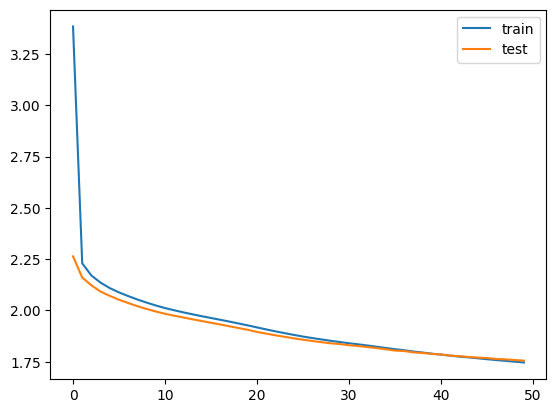

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# **5. 요약 모델 테스트**

In [63]:
### 테스트용 단어 사전 생성
src_index_to_word = src_tokenizer.index_word ### 원문(Text) 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index ### 요약(Summary) 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word ### 요약(Summary) 단어 집합에서 정수 -> 단어를 얻음


**1) Encoder 생성**

In [55]:
### Seq2Sew는 훈련 단계와 테스트 단계의 동작이 상이하여, 테스트 단계의 모델을 별도 생성
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

**2) Decoder 생성**

In [58]:
### 이전 시점의 상태 저장
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

### 문장의 다음 단어를 예측하기 위해 initial_state를 이전 시점의 상태 정보 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### Attention
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

### Decoder 출력층 (Attention 결과와 Decoder Hidden State 연결)
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

**3) Model 생성**

In [59]:
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**4) 테스트용 함수 생성**

In [60]:
def decode_sequence(input_seq):
    ### 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    ### <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_tokenizer.word_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sample_token_index  = np.argmax(output_tokens[0, -1, :])
        sampled_token       = tar_index_to_word[sample_token_index]

        if (sampled_token != 'eostoken'):
            decoded_sentence += ' '+sampled_token

        ### <EOS>이거나 최대 길이를 넘으면 중단
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        ### 길이가 1인 타겟 시퀀스 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sample_token_index

        ### 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence


In [61]:
### 원문 : 정수 시퀀스 -> 텍스트 시퀀스 변환
def seq2text(input_seq):
    sentence = ''
    for i in input_seq:
        if (i != 0):
            sentence = sentence + src_index_to_word[i] + ' '
    return sentence

### 요약문 : 정수 시퀀스 -> 텍스트 시퀀스 변환
def seq2summary(input_seq):
    sentence = ''
    for i in input_seq:
        if ((i != 0 and i != tar_tokenizer.word_index['sostoken']) and i != tar_tokenizer.word_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

**5) 테스트**

In [64]:
for i in range(500, 510):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  loved little packages quaker soft baked cereal bars bar pretty big satisfying definitely filling 
실제 요약문 : yummy 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
예측 요약문 :  great


원문 :  last review wrote true pan one exact opposite buttered popcorn jelly belly beans arrived today packaged labeled plastic bag explaining got exactly ordered beans fresh tasty jelly belly logo yellow bean expected vendor gets top opinion 
실제 요약문 : what difference vendor makes 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
예측 요약문 :  not bad


원문 :  coffee like bold flavor like coffee delicious convenient able brew cup time amazon easy deal well 
실제 요약문 : tassimo discs gevalia dark italian roast 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━